In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from mpl_toolkits.basemap import Basemap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
listings_df = pd.read_csv('../data/listings.csv')

In [3]:
print(listings_df.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

Right now there are too many variables to work with, so let's try to prune this down so we're not overfitting the data. 

First let's get rid of any column that has the same value for all entries:

In [50]:
single_vals = [col for col in listings_df.columns if len(listings_df[col].unique())==1]
single_vals

['scrape_id',
 'last_scraped',
 'experiences_offered',
 'market',
 'country_code',
 'country',
 'has_availability',
 'calendar_last_scraped',
 'requires_license',
 'license',
 'jurisdiction_names']

Next let's see if any variables are highly correlated. We want to include as few variables as possible while still capturing the range of informaiton, so it's ok to prune out a few of these that are already related. 

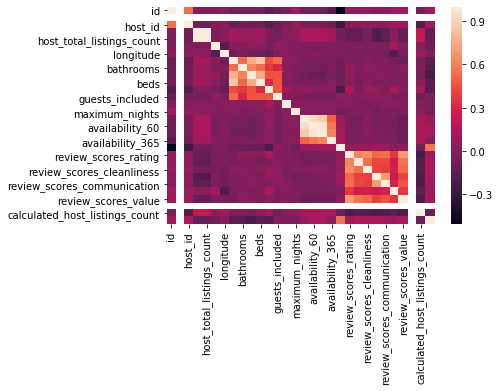

In [4]:
sns.heatmap(listings_df.corr());

In [52]:
def find_correlated_features(df,threshold):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return to_drop

In [55]:
# Drop features with > 60% correlation
corr_cols = find_correlated_features(listings_df,0.6)
corr_cols
# listings_df2 = listings_df.copy().drop(listings_df[cols_to_drop], axis=1)

['host_total_listings_count',
 'bedrooms',
 'beds',
 'availability_60',
 'availability_90',
 'availability_365',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_value']

**columns to include:**
host_response_time: 'within a few hours', 'within an hour', nan, 'within a day','a few days or more'
host_response_rate: re-group into <33%, 33-66%, 66-100% 
host_is_superhost: 'f','t',nan

**columns to exclude:**
any urls
'host_listings_count', 'host_total_listings_count','host_verifications', 'host_has_profile_pic', 'host_identity_verified',
'city', 'state','market','smart_location','country_code', 'country'

cleansing:
re-group host_response_rate into 1/3s
convert price from string to float

In [72]:
listings_df['reviews_per_month'].value_counts()

1.00     70
2.00     45
0.23     24
0.81     21
0.16     21
0.36     21
0.26     20
0.53     19
0.71     18
0.30     18
0.37     18
0.32     17
0.86     17
0.28     16
1.06     16
0.31     16
0.24     16
0.65     16
3.00     16
0.45     16
0.41     16
0.63     15
0.92     15
1.14     15
0.90     15
0.29     15
0.67     15
0.25     15
0.22     15
0.64     15
         ..
8.01      1
5.96      1
8.95      1
6.73      1
8.38      1
7.02      1
4.16      1
5.61      1
9.63      1
4.73      1
3.42      1
2.97      1
4.06      1
4.39      1
5.11      1
7.18      1
1.70      1
6.35      1
6.87      1
10.27     1
7.01      1
9.08      1
5.64      1
4.54      1
4.88      1
8.18      1
4.72      1
7.53      1
3.71      1
6.14      1
Name: reviews_per_month, Length: 654, dtype: int64

In [ ]:
cols_to_include = ['host_response_time','host_response_rate', 'host_acceptance_rate', 
                   'host_is_superhost','neighbourhood_cleansed','neighbourhood_group_cleansed',
                   'zipcode', 'latitude', 'longitude','property_type', 'room_type', 'accommodates',
                   'bathrooms', 'bed_type', 'square_feet','price', 'weekly_price', 'monthly_price', 
                   'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 
                   'minimum_nights','maximum_nights', 'calendar_updated', 'has_availability',
                   'availability_30', 'calendar_last_scraped', 'number_of_reviews','review_scores_rating',
                   'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 
                   'review_scores_communication', 'review_scores_location', 'review_scores_value',
                   'instant_bookable','cancellation_policy','calculated_host_listings_count','reviews_per_month']

In [9]:
listings_cat = listings_df.select_dtypes(include='object')

In [ ]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [ ]:
#Test function with the dataset
# cat_cols_lst = ...
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df,'review_scores_rating', cat_cols_lst, dummy_na=False)